# Змінні для роботи

### Змінна чи працюєте в Colab

In [5]:
isColab = False

### Шляхи до 2-ох датасетів


In [6]:
if isColab:
    # Вкажіть шлях до збережених датасетів на Google Drive. Наприклад:
    file_path = '/content/drive/MyDrive/colaaab/nn_course_project/dataset_final.txt'
    file_path3 = '/content/drive/MyDrive/colaaab/nn_course_project/filename.csv'
else:
    file_path = 'dataset_final.txt'
    file_path3 = 'filename.csv'

if isColab:
    # Вкажіть шлях для збереження preprocessed датасетів на Google Drive. Наприклад:
    your_drive_path_for_datasets = 'content/drive/MyDrive/colaaab/nn_course_project/saved_datasets'
    # Вкажіть шлях для збереження моделей на Google Drive. Наприклад:
    your_drive_path_for_models = 'content/drive/MyDrive/colaaab/nn_course_project/saved_models'


# Імпорт необхідних бібліотек

In [3]:
# Link to terminal commands to install tensor: https://www.tensorflow.org/install/pip
# for macos: python3 -m pip install tensorflow
# for windows: python -m pip install "tensorflow<2.11"

# pip install scikit-optimize

In [7]:
if isColab:
    !pip install nlpaug

In [8]:
if isColab:
    !pip install scikit-optimize

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk  # NLTK - Natural Language Processing Toolkit
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
import string

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten, LSTM, Dropout, GRU, Input, TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score,\
 precision_score, classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize 
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import random
import shutil

import nlpaug
import nlpaug.augmenter.word as naw
from skopt import BayesSearchCV

In [30]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [10]:
from keras.models import save_model
import joblib

In [11]:
if isColab:
    from google.colab import drive
    drive.mount('/content/drive')

In [12]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yurayano/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yurayano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Завантаження і попередня обробка датесету з воєнно забороненими повідомленнями

In [13]:
def txt_to_dataframe(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    lines = data.split('\n')
    lines.insert(0, 'order_number\tmessage')
    columns = lines[0].split('\t')

    data_dict = {}
    for column in columns:
        data_dict[column] = []

    for line in lines[1:]: 
        values = line.split('\t') 
        for column, value in zip(columns, values):
            if column == 'order_number':
              value = value[:-1]
              value = int(value)
            data_dict[column].append(value)

    dataframe = pd.DataFrame(data_dict)
    dataframe.drop('order_number', axis=1, inplace=True)

    # add label
    dataframe['label'] = 1

    return dataframe


In [14]:
dataframe_1 = txt_to_dataframe(file_path)


In [15]:
display(dataframe_1)
dataframe_1.info()

,message,label
0,There are currently 7 military units in the AT...,1
1,"The national army currently has more than 1,50...",1
2,"Yesterday, 3 armored vehicles belonging to the...",1
3,Military units are located along the front lin...,1
4,Military units continue to carry out reconnais...,1
...,...,...
946,According to information from a reliable sourc...,1
947,Ukrainian military personnel from the motorize...,1
948,The motorized rifle brigade conducts training ...,1
949,"According to operational information, the moto...",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  951 non-null    object
 1   label    951 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.0+ KB


Check for duplicates

In [16]:
duplicates = dataframe_1.duplicated()
print(duplicates.any())

True


In [17]:
def find_duplicates(dataset):
    duplicates = dataset.duplicated(keep=False)
    duplicate_indices = duplicates[duplicates].index.tolist()
    return duplicate_indices

find_duplicates(dataframe_1)

[360, 387]

Бачимо, що датасет містить 2 однакові повідомлення по індексу 360 та 387. Виведемо їх

In [18]:
find_duplicates(dataframe_1)

print(dataframe_1.loc[360].message)
print(dataframe_1.loc[387].message)

I saw that there was a rocket attack by the Ukrainians near the hospital in Avdiivka. Now they are moving to a new location. I will tell you the new location of their location later.
I saw that there was a rocket attack by the Ukrainians near the hospital in Avdiivka. Now they are moving to a new location. I will tell you the new location of their location later.


Напишемо та викличемо ф-ю для видалення дуплікатів

In [19]:
def remove_duplicates(dataset):
    deduplicated_dataset = dataset.drop_duplicates()
    return deduplicated_dataset

def delete_duplicates(df):
  df = df.drop_duplicates()
  df = df.reset_index(drop=True)

  if not df.duplicated().any():
    print('Duplicates deleted')
  else:
    print('Duplicates NOT deleted')
  return df

dataframe_1 = delete_duplicates(dataframe_1)
# dataframe_1 = dataframe_1.reset_index(drop=True)

duplicates = dataframe_1.duplicated()
print(duplicates.any())

Duplicates deleted
False


# Завантаження і попередня обробка датесету twitter war messages

In [20]:
dataframe_3_raw = pd.read_csv(file_path3)

In [21]:
display(dataframe_3_raw)
dataframe_3_raw.info()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1630366235354451969,1630152070530576385,2023-02-28 00:36:15 UTC,2023-02-28,00:36:15,0,1493761817406894086,tomasliptai,Tomas Liptai,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'nazijaeger__', 'name': 'nazi...",NaN,NaN,NaN,NaN
1,1630366226424778753,1630366226424778753,2023-02-28 00:36:13 UTC,2023-02-28,00:36:13,0,1526694166662721536,paperfloure,Smell the roses,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1630366225930027011,1630366225930027011,2023-02-28 00:36:13 UTC,2023-02-28,00:36:13,0,1053018392939167746,katetbar1,@etak,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1630366223056662530,1630351686974992385,2023-02-28 00:36:12 UTC,2023-02-28,00:36:12,0,602371247,jlhrdhmom,JLHrdh,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MainelifeR', 'name': 'Mainel...",NaN,NaN,NaN,NaN
4,1630366221483884545,1629903982255644672,2023-02-28 00:36:12 UTC,2023-02-28,00:36:12,0,1053594763214184448,phemikali,rolarkcybersecurity,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Pottingpinks', 'name': 'GRS'...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10009,1630331110415646721,1630305860298633216,2023-02-27 22:16:41 UTC,2023-02-27,22:16:41,0,998476071292035072,ahk14061,Andre🇳🇴🇺🇦,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'wallacemick', 'name': 'Mick ...",NaN,NaN,NaN,NaN
10010,1630331106305122304,1630202100369043459,2023-02-27 22:16:40 UTC,2023-02-27,22:16:40,0,1477276764908965889,marxistswon,Marxists Won,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'tom_username_', 'name': 'Tom...",NaN,NaN,NaN,NaN
10011,1630331106296844288,1630301689818275840,2023-02-27 22:16:40 UTC,2023-02-27,22:16:40,0,1616822734214037504,johngerver21,John Gerver,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'elonmusk', 'name': 'Elon Mus...",NaN,NaN,NaN,NaN
10012,1630331102480171009,1630181795101540357,2023-02-27 22:16:39 UTC,2023-02-27,22:16:39,0,25588052,late49er,Ben Davis,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'RonFilipkowski', 'name': 'Ro...",NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10014 non-null  int64  
 1   conversation_id  10014 non-null  int64  
 2   created_at       10014 non-null  object 
 3   date             10014 non-null  object 
 4   time             10014 non-null  object 
 5   timezone         10014 non-null  int64  
 6   user_id          10014 non-null  int64  
 7   username         10014 non-null  object 
 8   name             10014 non-null  object 
 9   place            3 non-null      object 
 10  tweet            10014 non-null  object 
 11  language         10014 non-null  object 
 12  mentions         10014 non-null  object 
 13  urls             10014 non-null  object 
 14  photos           10014 non-null  object 
 15  replies_count    10014 non-null  int64  
 16  retweets_count   10014 non-null  int64  
 17  likes_count 

Напишемо ф-ю, яка дістане N рандомних entries з pandas dataframe

In [22]:
def get_random_tweets(dataframe, n):
    # Створити порожній список для зберігання випадкових записів
    random_tweets = []
    
    # Фільтрувати DataFrame за умовою
    filtered_dataframe = dataframe[dataframe['tweet'].apply(lambda x: x.count('#') <= 4 and x.count('@') <= 4) & (dataframe['language'] == 'en')]
    
    # Перевірити, чи кількість відфільтрованих записів в DataFrame менше або рівна N
    if filtered_dataframe.shape[0] <= n:
        # Використовувати всі відфільтровані записи
        random_tweets = filtered_dataframe['tweet'].tolist()
    else:
        # Витягнути N випадкових записів з відфільтрованого DataFrame
        random_indices = random.sample(range(filtered_dataframe.shape[0]), n)
        random_tweets = filtered_dataframe.iloc[random_indices]['tweet'].tolist()
    
    return random_tweets

In [23]:
dataframe_3_filtered_messages = get_random_tweets(dataframe_3_raw, dataframe_1.shape[0])

In [24]:
len(dataframe_3_filtered_messages)

950

Створимо датасет з простими повідомленнями

In [25]:
data = {
    "message": dataframe_3_filtered_messages,
    "label": [0] * len(dataframe_3_filtered_messages)
}
dataframe_3 = pd.DataFrame(data)

In [26]:
duplicates = dataframe_3.duplicated()
print(duplicates.any())

False


In [27]:
if duplicates.any():
  dataframe_3 = delete_duplicates(dataframe_3)

In [28]:
dataframe_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  950 non-null    object
 1   label    950 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.0+ KB


In [29]:
dataframe_3

,message,label
0,@JackPosobiec Bold tweet As you call for war w...,0
1,"@rickygervais 1) Brexit, Brexit, Brexit, Brexi...",0
2,@Rabbithole45 @DC_Draino Putin is playing cons...,0
3,@chitowngirl1982 Elections in Israel are about...,0
4,@RebelNewsOnline Fascist in power arming NAZI ...,0
...,...,...
945,@Hose_Hound @JackPosobiec Yes. Isn’t it funny ...,0
946,"Hell, Russia should park its nuclear ICBMs in ...",0
947,Russia Relying on Rare 'Zoopark-1' Radar to Fi...,0
948,"@nurse_mdt @DC_Draino Russia invaded Ukraine, ...",0


# Обʼєднання датасетів, змішування 

In [35]:
combined_dataset = pd.concat([dataframe_1, dataframe_3], ignore_index=True) 

shuffled_combined_dataset = combined_dataset.sample(frac=1, random_state=477)
shuffled_combined_dataset = shuffled_combined_dataset.reset_index(drop=True)

shuffled_combined_dataset = shuffled_combined_dataset.sample(frac=1, random_state=4897)
shuffled_combined_dataset = shuffled_combined_dataset.reset_index(drop=True)

combined_dataset = shuffled_combined_dataset

In [223]:
display(combined_dataset.head())
display(combined_dataset['label'].value_counts())

,message,label
0,Ukrainian forces were observed moving towards ...,1
1,@RonFilipkowski He can move to Russia.,0
2,A convoy of Ukrainian military vehicles carryi...,1
3,I saw Shahed fly through the village of Novy Z...,1
4,@TheoFleury14 I stand by Ukraine in their batt...,0


1    950
0    950
Name: label, dtype: int64

# Поділ на train test data

In [37]:
X = combined_dataset['message']  # Features
y = combined_dataset['label']    # Target variable (forbidden or not forbidden)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) # 


In [39]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print(" ---------- y_train ----------- ")
print(y_train.value_counts())
print(" ---------- y_test ----------- ")
print(y_test.value_counts())

X_train.shape:  (1330,)
X_test.shape:  (570,)
 ---------- y_train ----------- 
0    665
1    665
Name: label, dtype: int64
 ---------- y_test ----------- 
1    285
0    285
Name: label, dtype: int64


In [40]:
def reset_indeces(sets):
  sets_res = []
  for set in sets:
    sets_res.append(set.reset_index(drop=True))
  return sets_res

X_train, X_test, y_train, y_test = reset_indeces([X_train, X_test, y_train, y_test])

# "Data Preprocessing" нашого X_train та X_test

In [42]:
def preprocess_twitter_dataset(tokenizer, datasetInput):
    dataset = datasetInput.copy()
    
    # Convert text to lowercase
    dataset['message'] = dataset['message'].str.lower()

    # Remove URLs
    dataset['message'] = dataset['message'].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))

    # Remove mentions and hashtags
    dataset['message'] = dataset['message'].apply(lambda x: re.sub(r"@\w+|#\w+", "", x))

    # Remove punctuations
    dataset['message'] = dataset['message'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))

    # Tokenization using TweetTokenizer
    dataset['message'] = dataset['message'].apply(tokenizer.tokenize)

    # Remove stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    dataset['message'] = dataset['message'].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatization
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    dataset['message'] = dataset['message'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    
    return dataset


In [43]:
tokenizerRegularExpression = nltk.RegexpTokenizer(r"\w+")

X_train_preprossed_twitter = preprocess_twitter_dataset(tokenizerRegularExpression, X_train.to_frame())
X_test_preprossed_twitter = preprocess_twitter_dataset(tokenizerRegularExpression, X_test.to_frame())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
X_train_preprossed_twitter

,message
0,"[wrong, support, strong, ukraine, weak, russia..."
1,"[missile, strike, hit, gas, pipeline, ivanofra..."
2,"[nato, threat, mutual, defence, alliance, one,..."
3,"[ukraine, using, germ, warfare, essential, rus..."
4,"[legacy, ssr, reason, fight, russia]"
...,...
1325,"[reconnaissance, drone, spotted, ukrainian, so..."
1326,"[report, shelling, donetsk, probably, kh30, mi..."
1327,"[report, coming, missile, strike, zaporizhzhia..."
1328,"[russian, hierarchy, wanted, jailed, killed, o..."


In [45]:
# обʼєднюємо слова в стрічку
X_train_preprossed_twitter  = [' '.join(doc) for doc in X_train_preprossed_twitter.message] 
X_test_preprossed_twitter  = [' '.join(doc) for doc in X_test_preprossed_twitter.message] 

In [46]:
print(len(X_train_preprossed_twitter))
print(len(X_test_preprossed_twitter))

display(X_train_preprossed_twitter[:2])
X_test_preprossed_twitter[:2]

1330
570


['wrong support strong ukraine weak russia american longer educated security clearance say push toward annexing russia',
 'missile strike hit gas pipeline ivanofrankivsk approximately 1000 according source']

['armed force ukraine troop spotted moving towards town kramatorsk coordinate 48730652 37539198 ahmat power',
 'people bandera set new outpost near village komyshuvakha coordinate 48360714 37204251 ahmat power']

In [48]:
import re

def check_for_symbols(messages):
    pattern = r'[\U00010000-\U0010ffff\u2600-\u26FF\u2700-\u27BF\u23E9-\u23FA\u23EC\u23F0-\u23F3\u231A\u3030\u3297\u3299\u203C\u2049\u2190-\u21FF]+'
    symbol_messages = []

    for message in messages:
        if re.search(pattern, message):
            symbol_messages.append(message)

    return symbol_messages

symbolic_messages = check_for_symbols(X_test_preprossed_twitter)
if symbolic_messages:
    print("Messages with symbols:")
    for message in symbolic_messages:
        print(message)
else:
    print("No messages with symbols.")

No messages with symbols.


In [179]:
def save_dataframe_to_csv(X, y, df_name_in_colab, drive_path_datasets):
    # Save the DataFrame to a CSV file in Colab
    local_path = f'/content/{df_name_in_colab}.csv'

    df = pd.DataFrame({'message':X, 'label':y})
    df.to_csv(local_path, index=False)

    # Move the file to Google Drive
    drive_path = f'/{drive_path_datasets}/{df_name_in_colab}.csv'
    shutil.move(local_path, drive_path)
    print(f"DataFrame saved to '{drive_path}'")

In [180]:
if isColab:
    save_dataframe_to_csv(X_train_preprossed_twitter, y_train, 'df_preprossed_train', your_drive_path_for_datasets)

DataFrame saved to '/content/drive/MyDrive/colaaab/nn_course_project/saved_datasets/df_preprossed_train.csv'


In [181]:
if isColab:
    save_dataframe_to_csv(X_test_preprossed_twitter, y_test, 'df_preprossed_test', your_drive_path_for_datasets)

DataFrame saved to '/content/drive/MyDrive/colaaab/nn_course_project/saved_datasets/df_preprossed_test.csv'


# Data Analysis

## Ф-я для побудови графіка частоти N слів в деякому датасеті



In [52]:
def plot_word_frequency(word_freq, ttl):
    words = [word for word, freq in word_freq]
    frequencies = [freq for word, freq in word_freq]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(ttl)
    # Rotate y-axis labels
    # for bar in bars:
    #     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() ,
    #              str(bar.get_height()), ha='center', va='bottom', rotation=90, color ='black', fontweight='demibold')
    plt.xticks(rotation=90)
    plt.show()

## Порахуємо частоту слів усього prepros датасету та покажемо N most frequent

In [53]:
from collections import Counter
word_count_preprossed_all = Counter()
for text in X_train_preprossed_twitter + X_test_preprossed_twitter: 
    for word in text.split():
        word_count_preprossed_all[word] += 1

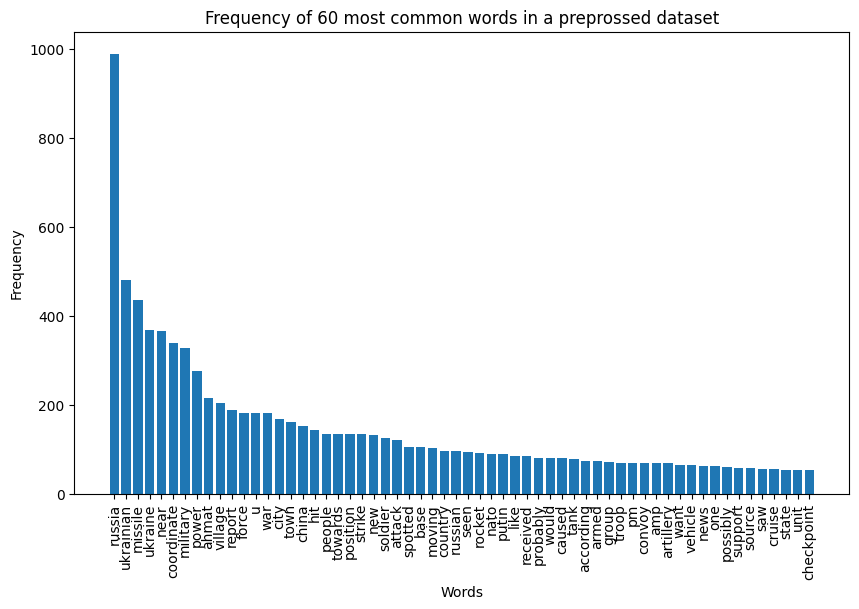

In [54]:
plot_word_frequency(word_count_preprossed_all.most_common(60),'Frequency of 60 most common words in a preprossed dataset')

## Ф-я для побудови графіка частоти усіх слів 

In [55]:
def plot_frequency(x, y, title, label):
    plt.plot(x, y, label=label)
    plt.xlabel('Word index')
    plt.ylabel('Word frequency')
    plt.title(title)
    plt.legend()
    plt.show()

  ## Покажемо частоту усіх слів preprossed dataset

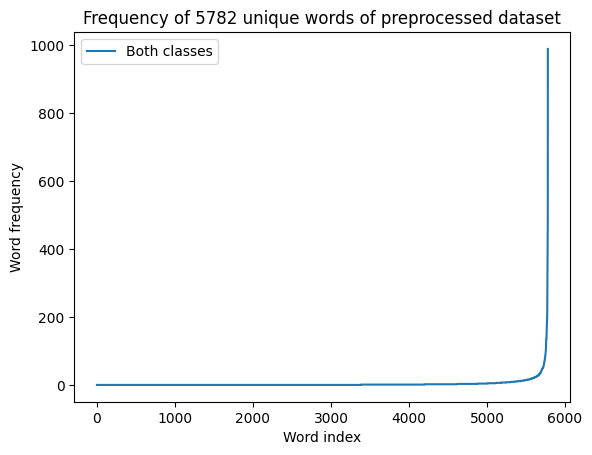

In [56]:
word_count_preprossed_all_sort = list(word_count_preprossed_all.values())
word_count_preprossed_all_sort.sort()

plot_frequency(np.arange(0,len(word_count_preprossed_all_sort),1), word_count_preprossed_all_sort ,
                f'Frequency of {len(word_count_preprossed_all_sort)} unique words of preprocessed dataset', 'Both classes')

In [57]:
display(len(X_train_preprossed_twitter + X_test_preprossed_twitter))
display(len(list(y_train) + list(y_test)))

1900

1900

# Functions for metrics

In [68]:
def plot_accuracy(history):
    # Get accuracy values from history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Plot accuracy curve
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [69]:
def plot_loss_curves(history):
    # Get loss values from history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Plot loss curve
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [70]:
def print_calc_metrics(model, X_test, y_test):
    y_pred_p = model.predict(X_test)
    y_pred = np.argmax(y_pred_p, axis=1)    
    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print('Balanced Accuracy: {:.4f} %'.format(balanced_acc*100))


In [71]:
def display_confusion_matrix(model, X_test, y_test, classNames): # ['Not Forbidden (0)', 'Forbidden (1)']
    y_pred_p = model.predict(X_test)
    y_pred_test = np.argmax(y_pred_p, axis=1)  
    
    displayed_labes = classNames

    cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=displayed_labes)

    cmap = plt.cm.Blues  # You can choose any colormap you like

    # Plot the confusion matrix with custom color
    fig, ax = plt.subplots(figsize=(7, 5))
    disp.plot(ax=ax, cmap=cmap)

    # Customize the colorbar
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=12)  # Adjust font size of colorbar labels

    # Add a title and axis labels
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)

    # Adjust tick labels' font size
    ax.set_xticklabels(displayed_labes, fontsize=10)
    ax.set_yticklabels(displayed_labes, fontsize=10)

    # Show the plot
    plt.show()

In [72]:
def roc_curve_display(model, X_test, y_test):
    y_pred_p = model.predict(X_test)
    y_test_pred = np.argmax(y_pred_p, axis=1) 

    # Calculate false positive rate (fpr), true positive rate (tpr), and threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_test_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [73]:
def display_all_metrics(history, model, modelName, X_test_tokenized, y_test, classNames):
  plot_loss_curves(history)
  plot_accuracy(history)
  print_calc_metrics(model, X_test_tokenized, y_test)
  display_confusion_matrix(model, X_test_tokenized, y_test, classNames)
  roc_curve_display(model, X_test_tokenized, y_test)

In [161]:
def displayClassificationReport(y_test, y_pred_test):
    print(classification_report(y_test, y_pred_test))

    report = classification_report(y_test, y_pred_test, output_dict=True)

    # Access the precision for class 0
    precision_class_0 = report['0']['precision']

    # Access the precision for class 1
    precision_class_1 = report['1']['precision']

    # Print the precise values without rounding
    print(f"Precision for Class 0: {precision_class_0:.16f}")
    print(f"Precision for Class 1: {precision_class_1:.16f}")

    # Access the precision for class 0
    recall_class_0 = report['0']['recall']

    # Access the recall for class 1
    recall_class_1 = report['1']['recall']

    # Print the precise values without rounding
    print(f"recall for Class 0: {recall_class_0:.16f}")
    print(f"recall for Class 1: {recall_class_1:.16f}")

In [163]:
def display_confusion_matrix2(y_test, y_pred_test):
    displayed_labes = ['Not Forbidden (0)', 'Forbidden (1)']

    cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=displayed_labes)

    cmap = plt.cm.Blues  # You can choose any colormap you like

    # Plot the confusion matrix with custom color
    fig, ax = plt.subplots(figsize=(7, 5))
    disp.plot(ax=ax, cmap=cmap)

    # Customize the colorbar
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=12)  # Adjust font size of colorbar labels

    # Add a title and axis labels
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)

    # Adjust tick labels' font size
    ax.set_xticklabels(displayed_labes, fontsize=10)
    ax.set_yticklabels(displayed_labes, fontsize=10)

    # Show the plot
    plt.show()

In [164]:
def roc_curve_display2(model, X_test, y_test):
    y_test_pred = model.predict(X_test)

    # Calculate false positive rate (fpr), true positive rate (tpr), and threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_test_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [170]:
def print_calc_metrics2(model, X_test, y_test):
    y_pred = model.predict(X_test)  
    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print('Balanced Accuracy: {:.4f} %'.format(balanced_acc*100))

# Models

In [155]:
def model_lstm(layers, units, dropout, learning_rate, ngrams, max_tokens):
  model = Sequential()
  encoder = TextVectorization(ngrams=ngrams, max_tokens=max_tokens)
  encoder.adapt(np.array(X_train_preprossed_twitter))

  model.add(encoder)

  model.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=128, mask_zero=True))

  for i in range(layers):
    if i == layers-1:
      model.add(LSTM(units))
      model.add(Dropout(dropout))
      break

    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))

  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [128]:
def model_rnn_n_gram(layers, units, dropout, learning_rate, ngrams, max_tokens):
  model = Sequential()

  encoder = TextVectorization(ngrams=ngrams, max_tokens=max_tokens)
  encoder.adapt(np.array(X_train_preprossed_twitter))

  model.add(encoder)

  model.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=128, mask_zero=True))

  for i in range(layers):
    if i == layers-1:
      model.add(SimpleRNN(units))
      model.add(Dropout(dropout))
      break

    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dropout(dropout))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

# Model execution

## --> DTC

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [151]:
# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
}


best_models_dtc_list = []
best_params_list = []
acc_train_dtc_saved = []
acc_test_dtc_saved = []

for max_tokens in [100, 200, 400, None]:
  for ngrams in [1,2]:
    print(f"============== max_tokens : {max_tokens} ==============")
    print(f"==============     ngrams : {ngrams}     ============")


    # Initialize TextVectorization
    vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,ngrams=ngrams)

    # Adapt the vectorizer to the train messages
    vectorizer.adapt(X_train_preprossed_twitter)

    # Tokenize train messages
    train_tokenized = vectorizer(X_train_preprossed_twitter).numpy()

    # Tokenize test messages
    test_tokenized = vectorizer(X_test_preprossed_twitter).numpy()

    # Create the DecisionTreeClassifier
    dt_classifier = DecisionTreeClassifier()

    # Perform grid search using cross-validation (5 fold)
    grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

    grid_search.fit(train_tokenized, y_train)

    # Get the best hyperparameter values
    best_params = grid_search.best_params_
    best_params_list.append(best_params)


    best_model_dtc = DecisionTreeClassifier(**best_params)
    best_models_dtc_list.append(best_model_dtc)

    # Fit the best model on the training data
    best_model_dtc.fit(train_tokenized, y_train)

    # ------------- Make predictions on the test set -------------
    y_pred_train_dtc = best_model_dtc.predict(train_tokenized)
    y_pred_test_dtc = best_model_dtc.predict(test_tokenized)

    # ------------- -------------------------------- -------------


    # ------------- Evaluate the best model -------------
    acc_train_dtc = accuracy_score(y_train, y_pred_train_dtc)
    acc_test_dtc = accuracy_score(y_test, y_pred_test_dtc)
    # ------------- ------------------------ -------------
    acc_train_dtc_saved.append(acc_train_dtc)
    acc_test_dtc_saved.append(acc_test_dtc)

    print("Accuracy train: ", acc_train_dtc)
    print("Accuracy test: ", acc_test_dtc)

============== max_tokens : 100 ==============
==============     ngrams : 1     ============
Accuracy train:  0.9368421052631579
Accuracy test:  0.8473684210526315
============== max_tokens : 100 ==============
==============     ngrams : 2     ============
Accuracy train:  0.968421052631579
Accuracy test:  0.8947368421052632
============== max_tokens : 200 ==============
==============     ngrams : 1     ============
Accuracy train:  0.8992481203007519
Accuracy test:  0.856140350877193
============== max_tokens : 200 ==============
==============     ngrams : 2     ============
Accuracy train:  0.9308270676691729
Accuracy test:  0.8508771929824561
============== max_tokens : 400 ==============
==============     ngrams : 1     ============
Accuracy train:  0.9
Accuracy test:  0.8578947368421053
============== max_tokens : 400 ==============
==============     ngrams : 2     ============
Accuracy train:  0.9082706766917293
Accuracy test:  0.8807017543859649
============== max_tokens :

In [153]:
best_model_dtc = DecisionTreeClassifier(**best_params_list[1])

vectorizer_dtc = tf.keras.layers.TextVectorization(max_tokens=100,ngrams=2)
vectorizer_dtc.adapt(X_train_preprossed_twitter)
train_tokenized = vectorizer_dtc(X_train_preprossed_twitter).numpy()
test_tokenized = vectorizer_dtc(X_test_preprossed_twitter).numpy()

# Fit the best model on the training data
best_model_dtc.fit(train_tokenized, y_train)

# ------------- Make predictions on the test set -------------
y_pred_train_dtc = best_model_dtc.predict(train_tokenized)
y_pred_test_dtc = best_model_dtc.predict(test_tokenized)

# ------------- -------------------------------- -------------

# ------------- Evaluate the best model -------------
acc_train_dtc = accuracy_score(y_train, y_pred_train_dtc)
acc_test_dtc = accuracy_score(y_test, y_pred_test_dtc)
# ------------- ------------------------ -------------

print("Accuracy train: ", acc_train_dtc)
print("Accuracy test: ", acc_test_dtc)

Accuracy train:  0.968421052631579
Accuracy test:  0.8912280701754386


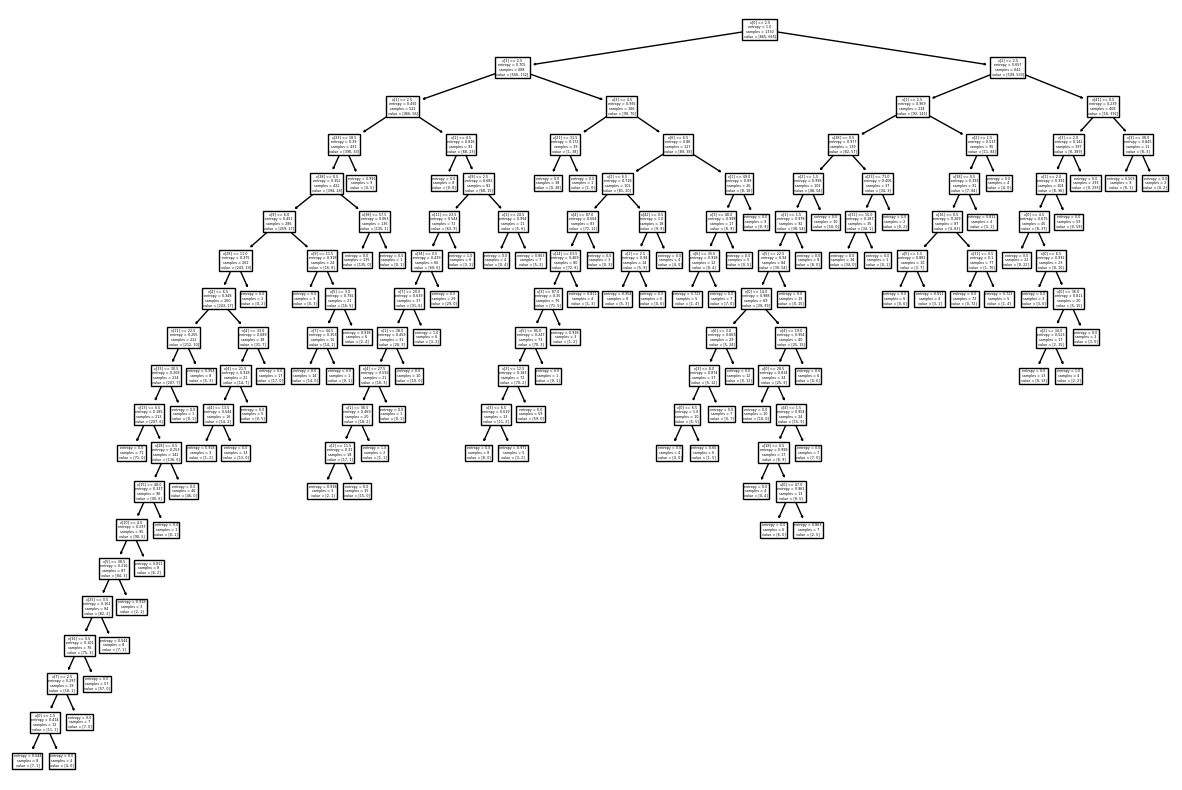

In [154]:
plt.figure(figsize=(15, 10))
plot_tree(best_model_dtc)
plt.show()

In [178]:
def save_model_to_drive(model, save_path, drive_path_for_models):
    # Mount Google Drive
    drive.mount('/content/drive')

    # Save the model to the specified path
    joblib.dump(model, save_path)

    # Move the saved model to Google Drive
    drive_path = f"/{drive_path_for_models}/{save_path}"
    !mv {save_path} {drive_path}

    print("Model saved to Google Drive.")


save_path = "DTC_best.joblib" 

# Save the dtc to Google Drive
if isColab:
    save_model_to_drive(best_model_dtc, save_path, your_drive_path_for_models)
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive.


## --> DTC metrics

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       285
           1       0.90      0.88      0.89       285

    accuracy                           0.89       570
   macro avg       0.89      0.89      0.89       570
weighted avg       0.89      0.89      0.89       570

Precision for Class 0: 0.8831615120274914
Precision for Class 1: 0.8996415770609320
recall for Class 0: 0.9017543859649123
recall for Class 1: 0.8807017543859649


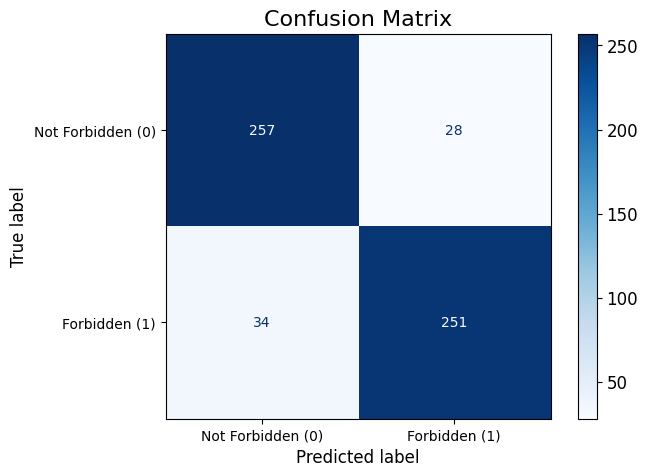

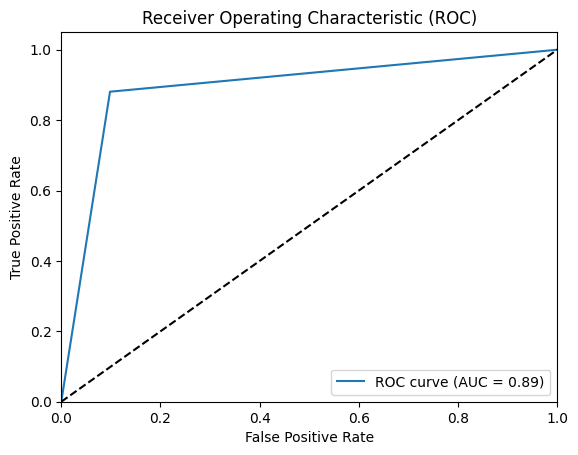

In [165]:
displayClassificationReport(y_test, y_pred_test_dtc)
display_confusion_matrix2(y_test, y_pred_test_dtc)
roc_curve_display2(best_model_dtc, test_tokenized, y_test)


In [171]:
print_calc_metrics2(best_model_dtc, test_tokenized, y_test)

Balanced Accuracy: 89.1228 %


## --> RNN

In [133]:
searchcv = BayesSearchCV(
  KerasClassifier(build_fn=model_rnn_n_gram),
  { 
      'layers': [2],
      'units': [32, 64],
      'dropout': [0.2, 0.3, 0.4],
      'learning_rate': [0.001, 0.01, 0.1],
      'ngrams': (1, 2),
      'max_tokens': (100, 200, 400, None),
      'epochs': (5,10),
      'batch_size': [16, 32],
  },
  n_iter=10,
  cv=2,
  verbose=2,
  scoring='accuracy'
)

callback = tf.keras.callbacks.EarlyStopping (monitor='loss', patience=3)

# searchcv.fit(X_train_tokenized, y_train, validation_data=(X_test_tokenized, y_test), callbacks=[callback])
searchcv.fit(np.array(X_train_preprossed_twitter), np.array(y_train),\
             validation_data=(np.array(X_test_preprossed_twitter), np.array(y_test)),\
             callbacks=[callback])


<ipython-input-133-0125f366d6c4>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=model_rnn_n_gram),


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/6
27/27 [==============================] - 8s 165ms/step - loss: 0.4554 - accuracy: 0.7459 - val_loss: 0.2270 - val_accuracy: 0.9439
Epoch 2/6
27/27 [==============================] - 3s 113ms/step - loss: 0.0618 - accuracy: 0.9895 - val_loss: 0.1519 - val_accuracy: 0.9649
Epoch 3/6
27/27 [==============================] - 2s 84ms/step - loss: 0.0227 - accuracy: 0.9970 - val_loss: 0.2532 - val_accuracy: 0.9561
Epoch 4/6
27/27 [==============================] - 2s 82ms/step - loss: 0.0372 - accuracy: 0.9925 - val_loss: 0.0956 - val_accuracy: 0.9825
Epoch 5/6
27/27 [==============================] - 2s 81ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1248 - val_accuracy: 0.9719
Epoch 6/6
21/21 [==============================] - 1s 19ms/step
[CV] END batch_size=25, dropout=0.2, epochs=6, layers=2, learning_rate=0.001, max_tokens=None, ngrams=2, units=45; total time=  22.9s
Epoch 1/6
27/27 [========================

BayesSearchCV(cv=2,
              estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8e90451d80>,
              n_iter=10, scoring='accuracy',
              search_spaces={'batch_size': [16, 32], 'dropout': [0.2, 0.3, 0.4],
                             'epochs': (5, 10), 'layers': [2],
                             'learning_rate': [0.001, 0.01, 0.1],
                             'max_tokens': (100, 200, 400, None),
                             'ngrams': (1, 2), 'units': [32, 64]},
              verbose=2)

In [134]:
print('BayesSearchCV Best parameters:', searchcv.best_params_)

rnn_best = model_rnn_n_gram(layers=searchcv.best_params_['layers'],
                  units=searchcv.best_params_['units'],
                  dropout=searchcv.best_params_['dropout'],
                  learning_rate=searchcv.best_params_['learning_rate'],
                  ngrams=searchcv.best_params_['ngrams'],
                  max_tokens=searchcv.best_params_['max_tokens'],
)

history = rnn_best.fit(np.array(X_train_preprossed_twitter),
                    np.array(y_train),
                    epochs=searchcv.best_params_['epochs'],
                    batch_size=searchcv.best_params_['batch_size'],
                    validation_data=(np.array(X_test_preprossed_twitter), np.array(y_test)))

BayesSearchCV Best parameters: OrderedDict([('batch_size', 25), ('dropout', 0.2), ('epochs', 6), ('layers', 2), ('learning_rate', 0.001), ('max_tokens', None), ('ngrams', 2), ('units', 45)])
Epoch 1/6
54/54 [==============================] - 10s 120ms/step - loss: 0.3531 - accuracy: 0.8218 - val_loss: 0.0183 - val_accuracy: 0.9965
Epoch 2/6
54/54 [==============================] - 5s 90ms/step - loss: 0.0294 - accuracy: 0.9925 - val_loss: 0.0291 - val_accuracy: 0.9947
Epoch 3/6
54/54 [==============================] - 5s 84ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9947
Epoch 4/6
54/54 [==============================] - 6s 113ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.9947
Epoch 5/6
54/54 [==============================] - 5s 99ms/step - loss: 0.0087 - accuracy: 0.9992 - val_loss: 0.0323 - val_accuracy: 0.9947
Epoch 6/6
54/54 [==============================] - 5s 90ms/step - loss: 0.0015 - accuracy: 1.0000 - val_lo

In [176]:
def save_model_to_drive(model, save_path):
    # Mount Google Drive
    drive.mount('/content/drive')

    # Save the model to the specified path
    save_model(model, save_path)

    # Move the saved model to Google Drive
    drive_path = "/content/drive/MyDrive/colaaab/nn_course_project/saved_models/" + save_path
    !mv {save_path} {drive_path}

    print("Model saved to Google Drive.")

save_path = "RNN_best.tf" 

# Save the RNN to Google Drive
if isColab:
    save_model_to_drive(rnn_best, save_path, your_drive_path_for_models)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model saved to Google Drive.


## --> RNN metrics

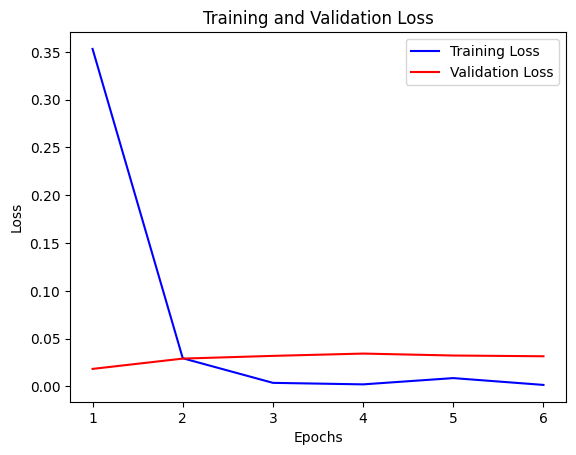

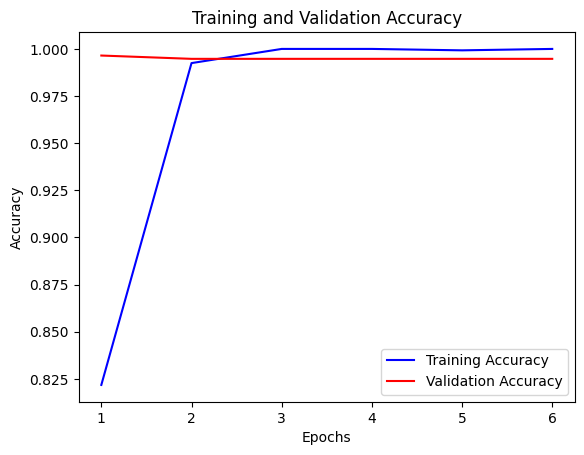

18/18 [==============================] - 1s 13ms/step
Balanced Accuracy: 99.4737 %
18/18 [==============================] - 0s 14ms/step


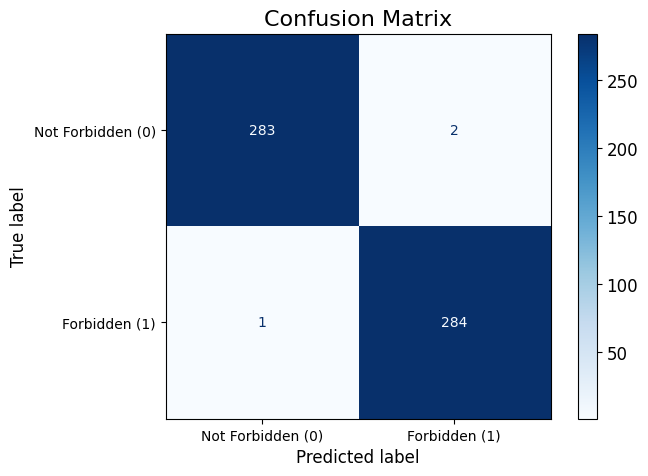

18/18 [==============================] - 0s 13ms/step


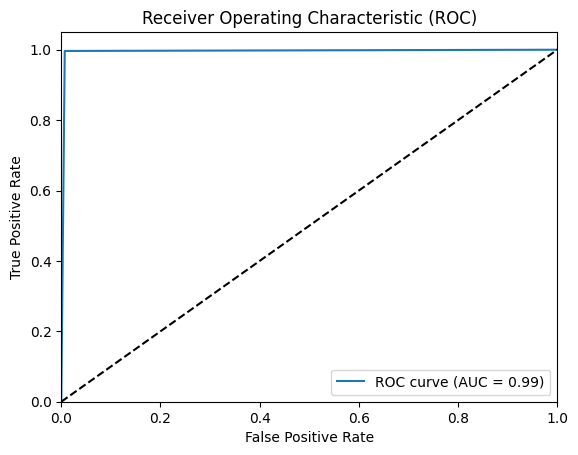

In [140]:
display_all_metrics(history, rnn_best, 'RNN', np.array(X_test_preprossed_twitter), np.array(y_test), ['Not Forbidden (0)', 'Forbidden (1)'])

In [168]:
y_pred_p_rnn = rnn_best.predict(np.array(X_test_preprossed_twitter))
y_pred_test_rnn = np.argmax(y_pred_p_rnn, axis=1) 

displayClassificationReport(y_test, y_pred_test_rnn)

18/18 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.99      1.00      0.99       285

    accuracy                           0.99       570
   macro avg       0.99      0.99      0.99       570
weighted avg       0.99      0.99      0.99       570

Precision for Class 0: 0.9964788732394366
Precision for Class 1: 0.9930069930069930
recall for Class 0: 0.9929824561403509
recall for Class 1: 0.9964912280701754


## --> LSTM

In [156]:
searchcv_lstm = BayesSearchCV(
  KerasClassifier(build_fn=model_lstm),
  { 
      'layers': [2],
      'units': [32, 64],
      'dropout': [0.2, 0.3, 0.4],
      'learning_rate': [0.001, 0.01, 0.1],
      'ngrams': (1, 2),
      'max_tokens': (100, 200, 400, None),
      'epochs': (5,10),
      'batch_size': [16, 32],
  },
  n_iter=10,
  cv=2,
  verbose=2,
  scoring='accuracy'
)

callback = tf.keras.callbacks.EarlyStopping (monitor='loss', patience=3)

# searchcv.fit(X_train_tokenized, y_train, validation_data=(X_test_tokenized, y_test), callbacks=[callback])
searchcv_lstm.fit(np.array(X_train_preprossed_twitter), np.array(y_train),\
             validation_data=(np.array(X_test_preprossed_twitter), np.array(y_test)),\
             callbacks=[callback])


<ipython-input-156-c35c1dc1e089>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=model_lstm),


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/5
25/25 [==============================] - 14s 224ms/step - loss: 0.2448 - accuracy: 0.9248 - val_loss: 0.0661 - val_accuracy: 0.9842
Epoch 2/5
25/25 [==============================] - 2s 64ms/step - loss: 0.1266 - accuracy: 0.9774 - val_loss: 0.0425 - val_accuracy: 0.9895
Epoch 3/5
25/25 [==============================] - 1s 56ms/step - loss: 0.0758 - accuracy: 0.9774 - val_loss: 0.0402 - val_accuracy: 0.9807
Epoch 4/5
25/25 [==============================] - 1s 55ms/step - loss: 0.0300 - accuracy: 0.9925 - val_loss: 0.0561 - val_accuracy: 0.9860
Epoch 5/5
21/21 [==============================] - 3s 14ms/step
[CV] END batch_size=27, dropout=0.2, epochs=5, layers=2, learning_rate=0.01, max_tokens=200, ngrams=1, units=52; total time=  27.1s
Epoch 1/5
25/25 [==============================] - 16s 232ms/step - loss: 0.2123 - accuracy: 0.9203 - val_loss: 0.1836 - val_accuracy: 0.9246
Epoch 2/5
25/25 [========================

BayesSearchCV(cv=2,
              estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8e88492f80>,
              n_iter=10, scoring='accuracy',
              search_spaces={'batch_size': [16, 32], 'dropout': [0.2, 0.3, 0.4],
                             'epochs': (5, 10), 'layers': [2],
                             'learning_rate': [0.001, 0.01, 0.1],
                             'max_tokens': (100, 200, 400, None),
                             'ngrams': (1, 2), 'units': [32, 64]},
              verbose=2)

In [158]:
print('BayesSearchCV Best parameters:', searchcv_lstm.best_params_)

lstm_best = model_lstm(layers=searchcv_lstm.best_params_['layers'],
                  units=searchcv_lstm.best_params_['units'],
                  dropout=searchcv_lstm.best_params_['dropout'],
                  learning_rate=searchcv_lstm.best_params_['learning_rate'],
                  ngrams=searchcv_lstm.best_params_['ngrams'],
                  max_tokens=searchcv_lstm.best_params_['max_tokens'],
)

history = lstm_best.fit(np.array(X_train_preprossed_twitter),
                    np.array(y_train),
                    epochs=searchcv_lstm.best_params_['epochs'],
                    batch_size=searchcv_lstm.best_params_['batch_size'],
                    validation_data=(np.array(X_test_preprossed_twitter), np.array(y_test)))

BayesSearchCV Best parameters: OrderedDict([('batch_size', 24), ('dropout', 0.3), ('epochs', 8), ('layers', 2), ('learning_rate', 0.001), ('max_tokens', 400), ('ngrams', 2), ('units', 58)])
Epoch 1/8
56/56 [==============================] - 22s 168ms/step - loss: 0.2823 - accuracy: 0.8767 - val_loss: 0.0538 - val_accuracy: 0.9877
Epoch 2/8
56/56 [==============================] - 5s 95ms/step - loss: 0.0481 - accuracy: 0.9925 - val_loss: 0.2768 - val_accuracy: 0.9509
Epoch 3/8
56/56 [==============================] - 6s 115ms/step - loss: 0.0727 - accuracy: 0.9895 - val_loss: 0.0530 - val_accuracy: 0.9877
Epoch 4/8
56/56 [==============================] - 6s 110ms/step - loss: 0.0193 - accuracy: 0.9977 - val_loss: 0.0275 - val_accuracy: 0.9947
Epoch 5/8
56/56 [==============================] - 5s 96ms/step - loss: 0.0110 - accuracy: 0.9977 - val_loss: 0.0541 - val_accuracy: 0.9947
Epoch 6/8
56/56 [==============================] - 7s 132ms/step - loss: 0.0473 - accuracy: 0.9910 - val_l

In [177]:
save_path = "LSTM_best.tf" 

# Save the LSTM to Google Drive
if isColab:
    save_model_to_drive(lstm_best, save_path, your_drive_path_for_models)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model saved to Google Drive.


## --> LSTM metrics

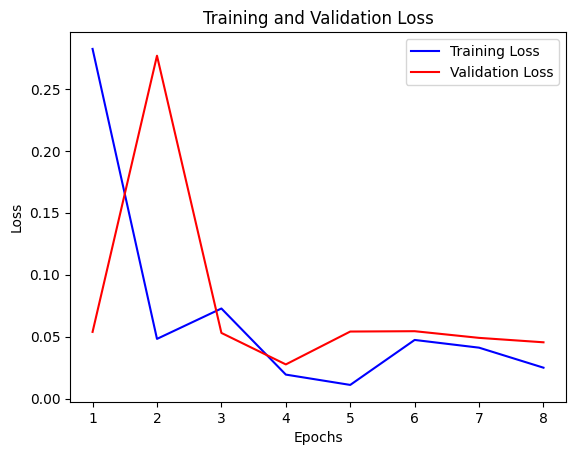

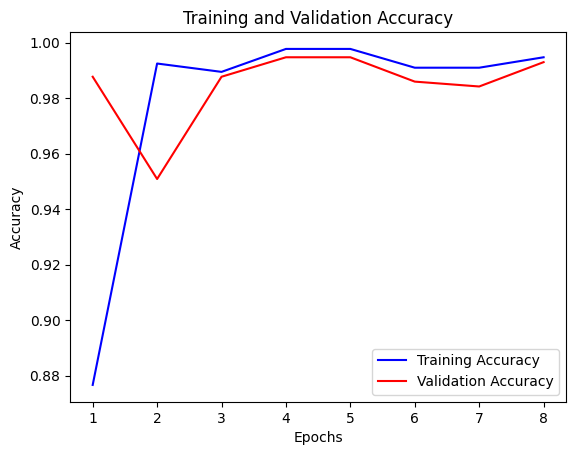

18/18 [==============================] - 3s 25ms/step
Balanced Accuracy: 99.2982 %
18/18 [==============================] - 0s 25ms/step


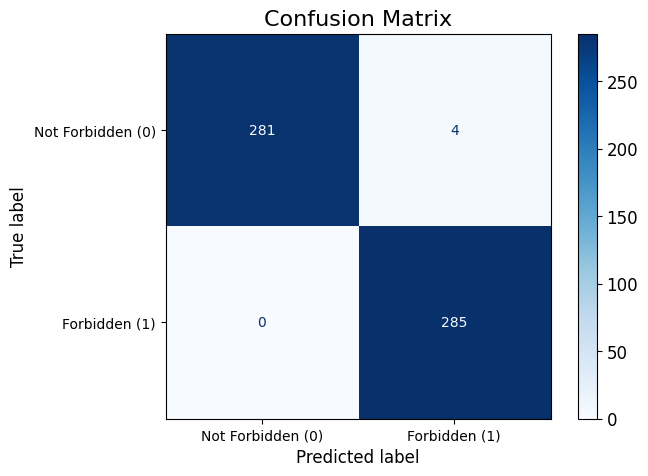

18/18 [==============================] - 0s 26ms/step


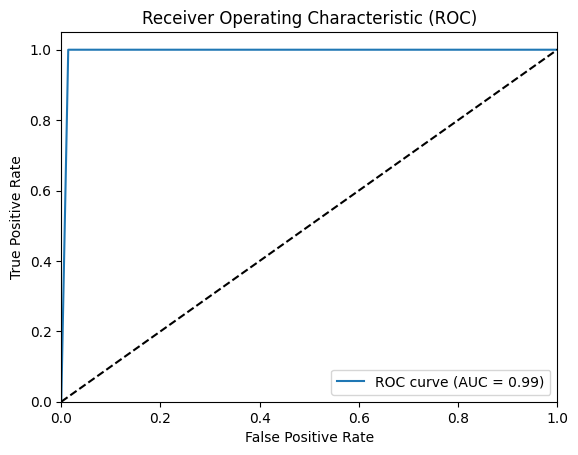

In [159]:
display_all_metrics(history, lstm_best, 'LSTM', np.array(X_test_preprossed_twitter), np.array(y_test), ['Not Forbidden (0)', 'Forbidden (1)'])

In [167]:
y_pred_p_lstm = lstm_best.predict(np.array(X_test_preprossed_twitter))
y_pred_test_lstm = np.argmax(y_pred_p_lstm, axis=1) 

displayClassificationReport(y_test, y_pred_test_lstm)

18/18 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.99      1.00      0.99       285

    accuracy                           0.99       570
   macro avg       0.99      0.99      0.99       570
weighted avg       0.99      0.99      0.99       570

Precision for Class 0: 1.0000000000000000
Precision for Class 1: 0.9861591695501730
recall for Class 0: 0.9859649122807017
recall for Class 1: 1.0000000000000000
